In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("WildfireAnalysis").getOrCreate()

# Load MODIS CSV data into DataFrame
modis_data = spark.read.csv("/content/fire_archive_M-C61_537264.csv", header=True, inferSchema=True)

# Show a few rows
modis_data.show(5)


+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
| 56.3398| -114.539|     324.3| 1.2|  1.1|2020-01-01|    1839|    Terra|     MODIS|         0|   6.03|     268.8|36.0|       D|   0|
| 55.6986| -115.865|     301.2| 1.0|  1.0|2020-01-04|    1910|    Terra|     MODIS|        45|   6.03|     268.4|10.2|       D|   0|
| 55.2304|-115.7741|     306.0| 1.1|  1.0|2020-01-04|    1910|    Terra|     MODIS|        62|   6.03|     271.2|13.3|       D|   0|
|  55.696| -115.849|     326.5| 1.0|  1.0|2020-01-04|    1910|    Terra|     MODIS|        84|   6.03|     269.2|32.0|       D|   0|
| 51.7363|-121.3927|     306.6| 1.0|  1.0|2020-01-04|    2057|     Aq

In [24]:
modis_data.filter(modis_data.type==3).show()


+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+-----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31|  frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+-----+--------+----+
| 43.6029| -65.4678|     419.2| 1.2|  1.1|2023-05-29|    1754|     Aqua|     MODIS|       100|  61.03|     306.6|  0.0|       D|   3|
| 50.4991| -59.5813|     371.5| 1.9|  1.3|2024-06-21|    1459|    Terra|     MODIS|       100|  61.03|     294.1|312.5|       D|   3|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+-----+--------+----+



In [3]:
# Print schema of the data
modis_data.printSchema()

# Display summary statistics for numeric columns
modis_data.describe(["brightness", "confidence", "frp"]).show()


root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- brightness: double (nullable = true)
 |-- scan: double (nullable = true)
 |-- track: double (nullable = true)
 |-- acq_date: date (nullable = true)
 |-- acq_time: integer (nullable = true)
 |-- satellite: string (nullable = true)
 |-- instrument: string (nullable = true)
 |-- confidence: integer (nullable = true)
 |-- version: double (nullable = true)
 |-- bright_t31: double (nullable = true)
 |-- frp: double (nullable = true)
 |-- daynight: string (nullable = true)
 |-- type: integer (nullable = true)

+-------+------------------+------------------+-----------------+
|summary|        brightness|        confidence|              frp|
+-------+------------------+------------------+-----------------+
|  count|            482354|            482354|           482354|
|   mean|335.37153563565863| 67.92513589604316|121.7001915605556|
| stddev|30.860949194443915|30.540574910678398|318.9555668458173|
|   

In [4]:
# Filter for approximate coordinates of Canada
canada_data = modis_data.filter((modis_data.latitude >= 41.6) & (modis_data.latitude <= 83.1) &
                                (modis_data.longitude >= -141.0) & (modis_data.longitude <= -52.6))

canada_data.show(5)


+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
| 56.3398| -114.539|     324.3| 1.2|  1.1|2020-01-01|    1839|    Terra|     MODIS|         0|   6.03|     268.8|36.0|       D|   0|
| 55.6986| -115.865|     301.2| 1.0|  1.0|2020-01-04|    1910|    Terra|     MODIS|        45|   6.03|     268.4|10.2|       D|   0|
| 55.2304|-115.7741|     306.0| 1.1|  1.0|2020-01-04|    1910|    Terra|     MODIS|        62|   6.03|     271.2|13.3|       D|   0|
|  55.696| -115.849|     326.5| 1.0|  1.0|2020-01-04|    1910|    Terra|     MODIS|        84|   6.03|     269.2|32.0|       D|   0|
| 51.7363|-121.3927|     306.6| 1.0|  1.0|2020-01-04|    2057|     Aq

In [5]:
from pyspark.sql.functions import year, month, dayofmonth

# Extract year, month, day from acquisition date
canada_data = canada_data.withColumn("year", year("acq_date"))
canada_data = canada_data.withColumn("month", month("acq_date"))
canada_data = canada_data.withColumn("day", dayofmonth("acq_date"))


In [6]:
# Example: Aggregate average brightness by month and year
monthly_brightness = canada_data.groupBy("year", "month").avg("brightness").orderBy("year", "month")
monthly_brightness.show()


+----+-----+------------------+
|year|month|   avg(brightness)|
+----+-----+------------------+
|2020|    1|  319.589756097561|
|2020|    2| 322.3236363636363|
|2020|    3|313.16086956521735|
|2020|    4|316.18425357873207|
|2020|    5| 323.4210254756532|
|2020|    6| 331.2397473997027|
|2020|    7| 319.2622112211221|
|2020|    8|321.74902162718894|
|2020|    9|317.82860858257436|
|2020|   10|318.64076773566563|
|2020|   11| 317.7458726415095|
|2020|   12| 320.7354838709677|
|2021|    1| 323.9285714285716|
|2021|    2| 327.4641025641025|
|2021|    3| 314.6661538461538|
|2021|    4|317.61131078224156|
|2021|    5|339.32756172839464|
|2021|    6|340.14980694980653|
|2021|    7| 335.2666598556084|
|2021|    8| 332.6147548954581|
+----+-----+------------------+
only showing top 20 rows



In [7]:
canada_data.write.csv("processed_canada_wildfire_data.csv", header=True)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data into Pandas
df = pd.read_csv("/content/processed_canada_wildfire_data.csv/part-00000-16eb83b5-f3f9-45e0-a282-122806b0d6b1-c000.csv")


In [12]:
import folium
from folium.plugins import HeatMap

# Create a map centered around Canada
m = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

# Add heatmap for fire locations with brightness as intensity
heat_data = [[row['latitude'], row['longitude'], row['brightness']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(m)

# Save and display the map
m.save("canada_wildfire_heatmap.html")


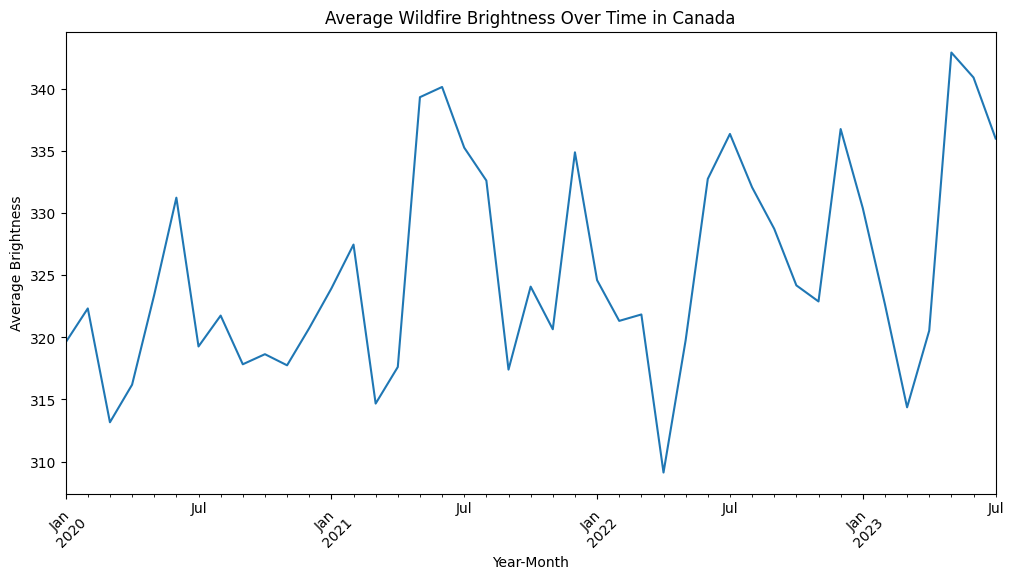

In [13]:
# Convert date columns to datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Group by year and month
df['year_month'] = df['acq_date'].dt.to_period('M')
brightness_trend = df.groupby('year_month')['brightness'].mean()

# Plot the brightness trend
plt.figure(figsize=(12, 6))
brightness_trend.plot()
plt.title("Average Wildfire Brightness Over Time in Canada")
plt.xlabel("Year-Month")
plt.ylabel("Average Brightness")
plt.xticks(rotation=45)
plt.show()


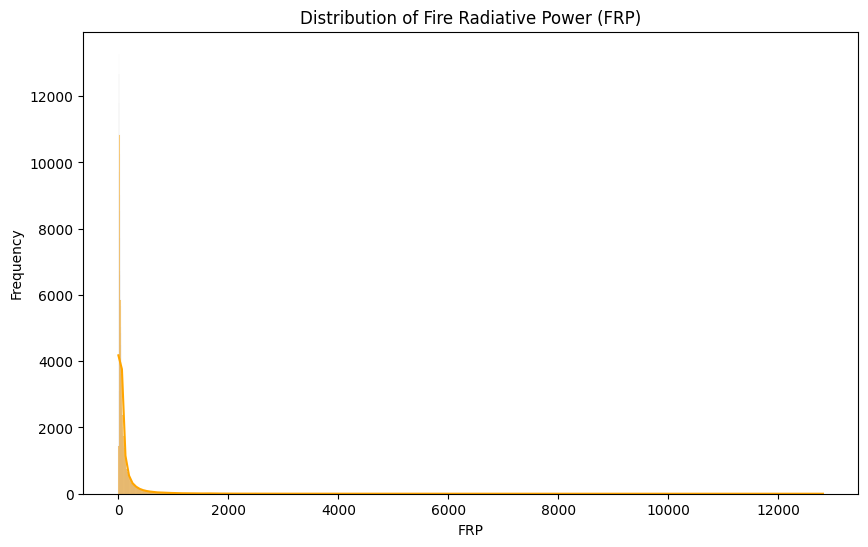

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['frp'], kde=True, color='orange')
plt.title("Distribution of Fire Radiative Power (FRP)")
plt.xlabel("FRP")
plt.ylabel("Frequency")
plt.show()


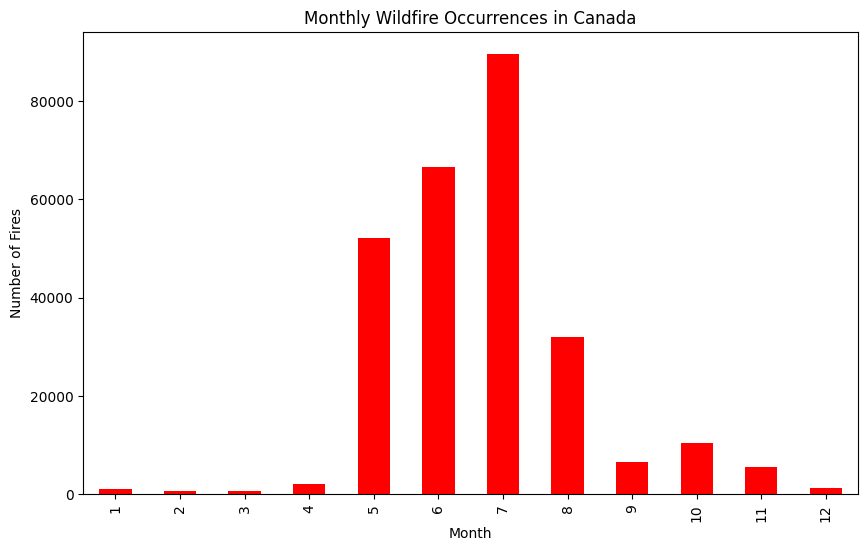

In [15]:
# Extract month from acquisition date
df['month'] = df['acq_date'].dt.month

# Count fires by month
monthly_fire_counts = df['month'].value_counts().sort_index()

# Plot monthly fire counts
plt.figure(figsize=(10, 6))
monthly_fire_counts.plot(kind='bar', color='red')
plt.title("Monthly Wildfire Occurrences in Canada")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.show()


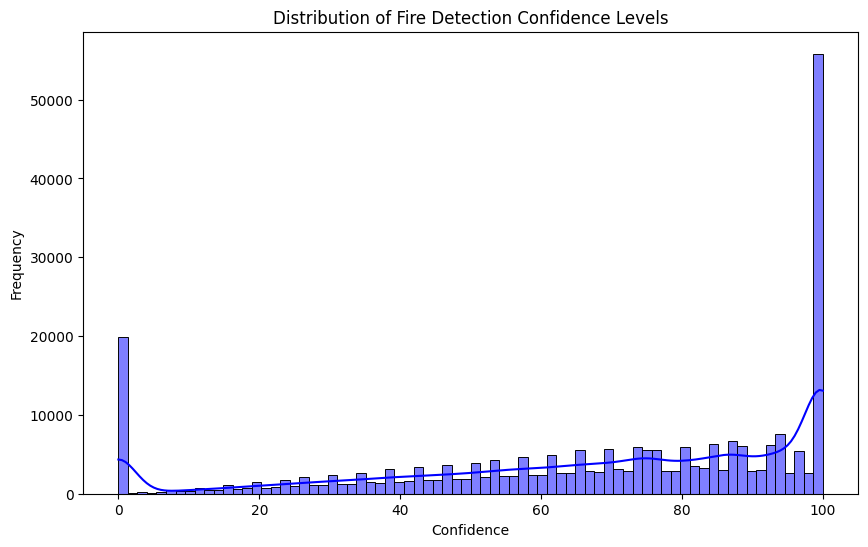

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['confidence'], kde=True, color='blue')
plt.title("Distribution of Fire Detection Confidence Levels")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()


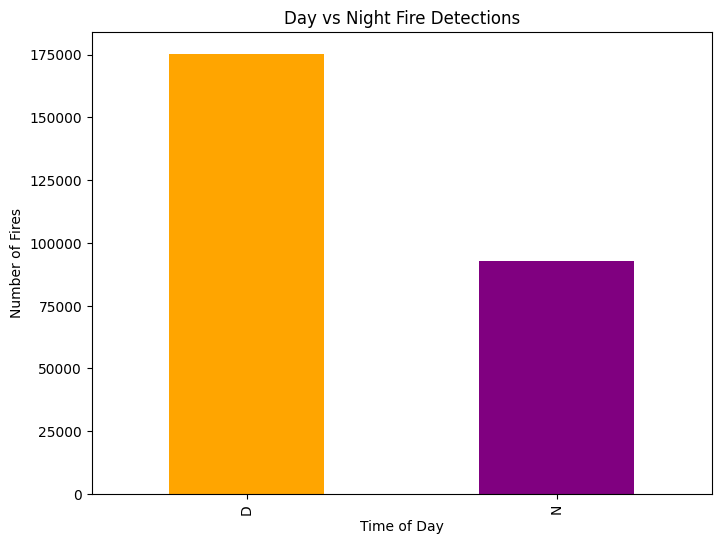

In [17]:
# Count day vs night fires
daynight_counts = df['daynight'].value_counts()

# Plot day vs night fire counts
plt.figure(figsize=(8, 6))
daynight_counts.plot(kind='bar', color=['orange', 'purple'])
plt.title("Day vs Night Fire Detections")
plt.xlabel("Time of Day")
plt.ylabel("Number of Fires")
plt.show()


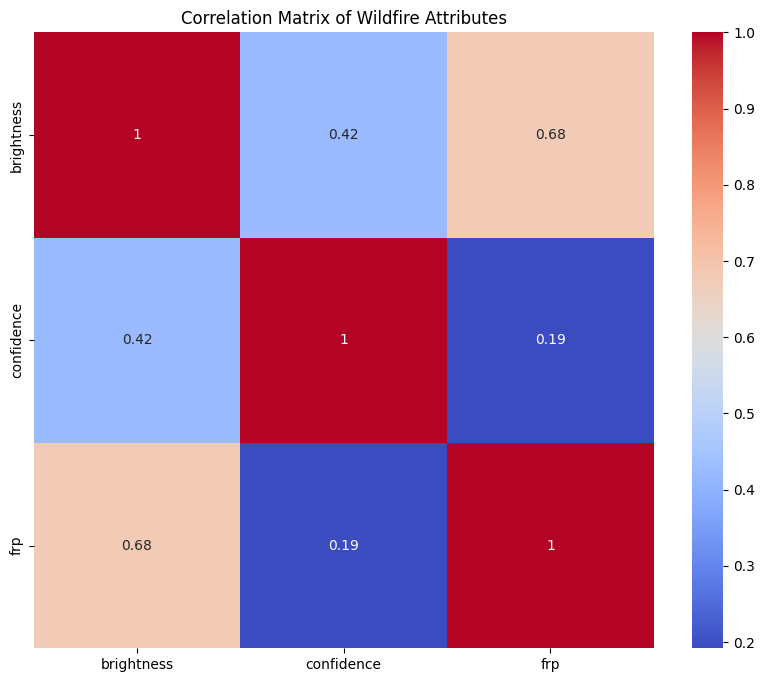

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[['brightness', 'confidence', 'frp']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Wildfire Attributes")
plt.show()


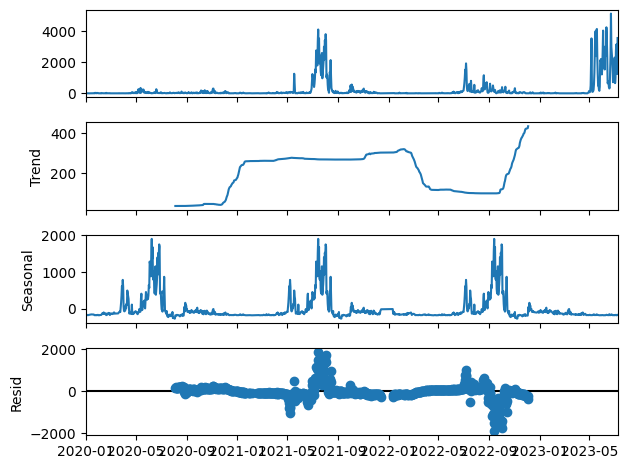

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Group data by date to count fires per day
daily_fires = df.groupby('acq_date').size()
decomposition = seasonal_decompose(daily_fires, model='additive', period=365)

# Plot decomposition
decomposition.plot()
plt.show()
